In [61]:
import os
import argparse
import torch
import math
import random
import numpy as np
import torch.nn as nn
import torch.optim as optim
from torchvision import transforms
from torch.optim.lr_scheduler import CosineAnnealingLR, StepLR

from torch.utils.data import DataLoader
from torch.utils.data import Dataset, DataLoader
import sklearn.metrics as metrics
from skimage.exposure import rescale_intensity
from skimage import morphology
from scipy import ndimage

from tqdm.notebook import tqdm
from importlib import reload

import pydicom as dicom
import pylibjpeg

import matplotlib.pyplot as plt
import cv2


In [73]:
def build_training_dataset(config):
    if config == None:
        batch_size = 4
        num_adjacent_slices = 3
    else:
        batch_size = config.batch_size
        num_adjacent_slices = config.num_adjacent_slices
        pass

    def _get_window_center(ds: dicom.dataset.FileDataset) -> np.float32:
            return np.float32(ds[0x5200, 0x9229][0][0x0028, 0x9132][0][0x0028, 0x1050].value)


    def _get_window_width(ds: dicom.dataset.FileDataset) -> np.float32:
        return np.float32(ds[0x5200, 0x9229][0][0x0028, 0x9132][0][0x0028, 0x1051].value)


    def _remove_noise(slice):
        segmentation = morphology.dilation(slice, np.ones((1, 1)))
        labels, label_nb = ndimage.label(segmentation)
        
        label_count = np.bincount(labels.ravel().astype(np.int))
        label_count[0] = 0

        mask = labels == label_count.argmax()
    
        mask = morphology.dilation(mask, np.ones((1, 1)))
        mask = ndimage.morphology.binary_fill_holes(mask)
        mask = morphology.dilation(mask, np.ones((3, 3)))
        masked_image = mask * slice    
        return masked_image


    class DICOM_Dataset(Dataset):
        def __init__(self, data_dir, transform=None):
            self.data_dir = data_dir
            self.transform = transform
            self.data = []
            # walk through the directory and get all the .dcm files
            for root, dirs, files in os.walk(data_dir):
                for file in files:
                    if file.endswith('.dcm'):
                        self.data.append(os.path.join(root, file))
            self.data.sort()

        def __len__(self):
            return len(self.data)


        def __preproc__(self, filepath):
            ds = dicom.dcmread(filepath)
            ds.decompress(handler_name="pylibjpeg")
            pixel_array = ds.pixel_array
            
            """ Rescale image pixel intensity values """
            window_center = _get_window_center(ds)
            window_width = _get_window_width(ds)

            low = (2 * window_center - window_width) / 2
            high = (2 * window_center + window_width) / 2
            
            pixel_array = rescale_intensity(
                pixel_array, in_range=(low, high), out_range="dtype"
            )
            
            """ Get a random set of adjacent slices """
            random_start_slice = random.randint(0, pixel_array.shape[0] - num_adjacent_slices)
            slices = pixel_array[random_start_slice:random_start_slice + num_adjacent_slices] 
            
            """ Remove noise from the slices """
            slices = np.array([_remove_noise(s) for s in slices])
            
            """ Normalize the slices to be the same size """
            slices = np.array([cv2.resize(s, (1024, 1024)) for s in slices])   

            return slices


        def __getitem__(self, idx):
            filepath = self.data[idx]
            slices = self.__preproc__(filepath)
            # convert numpy array to dtype float32
            slices = slices.astype(np.float32)
            if self.transform:
                slices = self.transform(slices)
            return slices

    train_dataset = DICOM_Dataset(data_dir='data/training', transform=None)
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    return train_loader

In [74]:
def train(config = None):
    train_loader = build_training_dataset(config)
    for i, batch in enumerate(train_loader):
        print(batch.shape)
        # Batch shape is [batch_size, num_adjacent_slices, height, width]
        return batch
        break

In [75]:
batch_of_slices = train()

c:\Users\gunnerstone\.conda\envs\treely\lib\site-packages\openjpeg\utils.py:210: UserWarning: The (0028,0101) Bits Stored value '10' in the dataset does not match the component precision value '16' found in the JPEG 2000 data. It's recommended that you change the Bits Stored value to produce the correct output
  f"The (0028,0101) Bits Stored value '{bits_stored}' in the "
c:\Users\gunnerstone\.conda\envs\treely\lib\site-packages\ipykernel_launcher.py:22: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


torch.Size([4, 3, 1024, 1024])


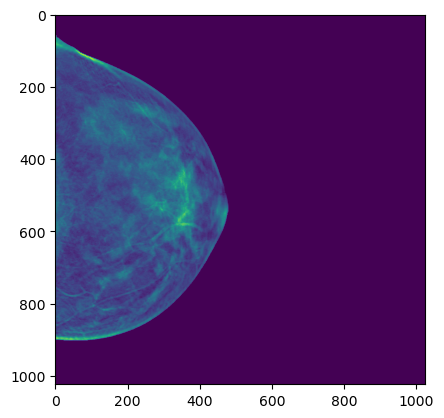

In [76]:
# plot the first slice of the first patient
plt.imshow(batch_of_slices[0][0])

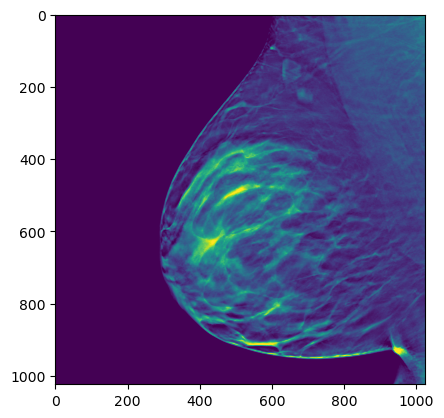

In [77]:
# plot the first slice of the first patient
plt.imshow(batch_of_slices[1][0])

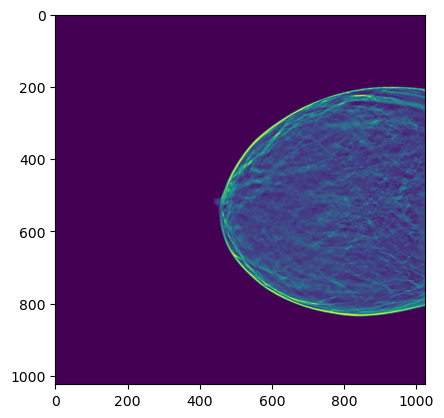

In [78]:
# plot the first slice of the first patient
plt.imshow(batch_of_slices[2][0])

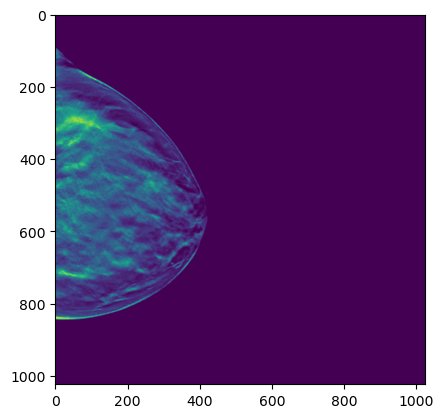

In [79]:
# plot the first slice of the first patient
plt.imshow(batch_of_slices[3][0])

In [81]:
train_loader = build_training_dataset(None)
print(len(train_loader))

291
